# Ethereum RNN Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
ethereum_csv = os.path.join(current_folder, "data","ethereum_hourly.csv")
ethereum_df = pd.read_csv(ethereum_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
ethereum_df['highLowDif'] = ethereum_df['highPriceUsd'] - ethereum_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
ethereum_df['datetime'] = pd.to_datetime(ethereum_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = ethereum_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = ethereum_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = ethereum_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [2]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [3]:
ethereum_df.iloc[0]

datetime                       2021-02-03 00:00:00+00:00
ethereum_count                                       508
ethereum_polarity                               0.172375
ethereum_subjectivity                           0.489083
ethereum_polarity_zeros                        0.0981143
ethereum_subjectivity_zeros                     0.321798
openPriceUsd                                     1514.77
closePriceUsd                                    1520.24
highPriceUsd                                     1530.61
lowPriceUsd                                      1514.77
volume                                       44437743410
marketcap                                   174085432619
highLowDif                                       15.8376
Name: 0, dtype: object

In [4]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'ethereum_polarity', 'ethereum_subjectivity', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [5]:
timeperiod_df.iloc[0]

ethereum_count                 5.080000e+02
ethereum_polarity_zeros        9.811427e-02
ethereum_subjectivity_zeros    3.217984e-01
closePriceUsd                  1.520244e+03
highPriceUsd                   1.530607e+03
lowPriceUsd                    1.514770e+03
volume                         4.443774e+10
Name: 0, dtype: float64

In [6]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
Input shape: (128, 120, 7)
Target shape: (128, 1)


Epoch 1/20
13/13 [==============================] - 8s 323ms/step - loss: 1.3649 - val_loss: 3.6020
Epoch 2/20
13/13 [==============================] - 3s 248ms/step - loss: 0.6233 - val_loss: 3.8863
Epoch 3/20
13/13 [==============================] - 3s 242ms/step - loss: 0.4389 - val_loss: 3.6318
Epoch 4/20
13/13 [==============================] - 3s 248ms/step - loss: 0.3890 - val_loss: 3.1015
Epoch 5/20
13/13 [==============================] - 3s 223ms/step - loss: 0.3618 - val_loss: 3.5066
Epoch 6/20
13/13 [==============================] - 3s 231ms/step - loss: 0.3385 - val_loss: 5.4599
Epoch 7/20
13/13 [==============================] - 3s 271ms/step - loss: 0.3699 - val_loss: 3.9036
Epoch 8/20
13/13 [==============================] - 3s 236ms/step - loss: 0.2900 - val_loss: 2.6185
Epoch 9/20
13/13 [==============================] - 3s 226ms/step - loss: 0.2665 - val_loss: 6.3598
Epoch 10/20
13/13 [==============================] - 3s 226ms/step - loss: 0.2629 - val_loss: 3.3509

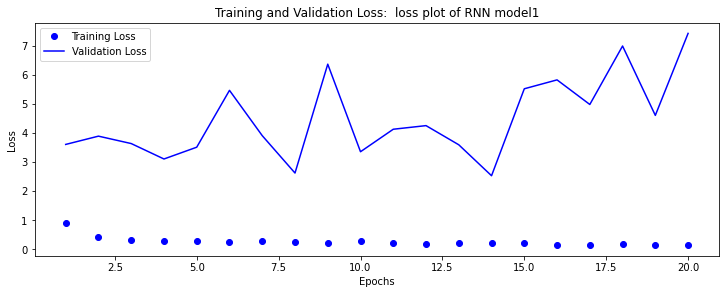

In [7]:
RNN_model1 = models.Sequential()
RNN_model1.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model1.add(layers.SimpleRNN(100))


RNN_model1.add(layers.Dense(1))

RNN_model1.compile(optimizer=RMSprop(), loss='mse')
RNN_model1_history = RNN_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model1_history, "loss plot of RNN model1")

Epoch 1/20
13/13 [==============================] - 6s 347ms/step - loss: 1.0292 - val_loss: 3.0629
Epoch 2/20
13/13 [==============================] - 3s 254ms/step - loss: 0.8785 - val_loss: 3.0022
Epoch 3/20
13/13 [==============================] - 4s 312ms/step - loss: 0.6728 - val_loss: 2.6672
Epoch 4/20
13/13 [==============================] - 4s 284ms/step - loss: 0.6654 - val_loss: 2.5952
Epoch 5/20
13/13 [==============================] - 3s 259ms/step - loss: 0.5617 - val_loss: 2.4771
Epoch 6/20
13/13 [==============================] - 4s 288ms/step - loss: 0.4517 - val_loss: 3.0613
Epoch 7/20
13/13 [==============================] - 5s 356ms/step - loss: 0.3712 - val_loss: 2.6582
Epoch 8/20
13/13 [==============================] - 5s 362ms/step - loss: 0.4707 - val_loss: 2.5813
Epoch 9/20
13/13 [==============================] - 3s 264ms/step - loss: 0.3696 - val_loss: 2.2165
Epoch 10/20
13/13 [==============================] - 3s 262ms/step - loss: 0.3207 - val_loss: 2.0100

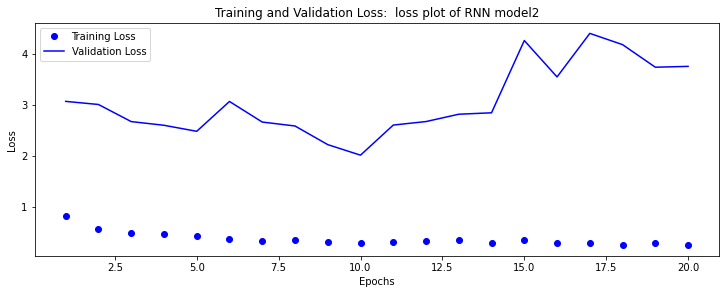

In [8]:
RNN_model2 = models.Sequential()
RNN_model2.add(layers.SimpleRNN(100, return_sequences=True,dropout=0.2, recurrent_dropout=0.2,input_shape=(shape_1, shape_2)))

RNN_model2.add(layers.SimpleRNN(100))


RNN_model2.add(layers.Dense(1))

RNN_model2.compile(optimizer=RMSprop(), loss='mse')
RNN_model2_history = RNN_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model2_history, "loss plot of RNN model2")

Epoch 1/30
13/13 [==============================] - 5s 297ms/step - loss: 0.7529 - val_loss: 5.3380
Epoch 2/30
13/13 [==============================] - 3s 205ms/step - loss: 0.5137 - val_loss: 4.4894
Epoch 3/30
13/13 [==============================] - 3s 243ms/step - loss: 0.4201 - val_loss: 3.8055
Epoch 4/30
13/13 [==============================] - 2s 186ms/step - loss: 0.3513 - val_loss: 3.4713
Epoch 5/30
13/13 [==============================] - 2s 191ms/step - loss: 0.3705 - val_loss: 3.3976
Epoch 6/30
13/13 [==============================] - 3s 195ms/step - loss: 0.3205 - val_loss: 3.2033
Epoch 7/30
13/13 [==============================] - 2s 188ms/step - loss: 0.2799 - val_loss: 3.3732
Epoch 8/30
13/13 [==============================] - 3s 203ms/step - loss: 0.2727 - val_loss: 4.0285
Epoch 9/30
13/13 [==============================] - 4s 342ms/step - loss: 0.2381 - val_loss: 3.8032
Epoch 10/30
13/13 [==============================] - 2s 189ms/step - loss: 0.2194 - val_loss: 4.0817

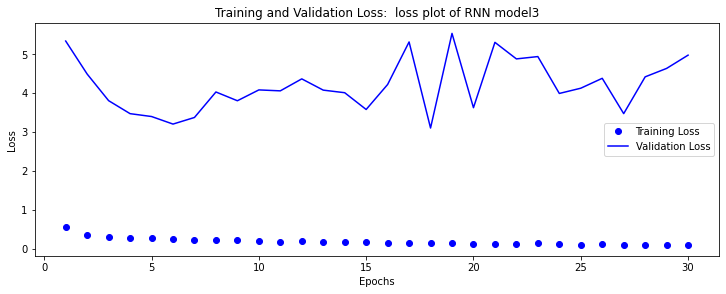

In [9]:
RNN_model3 = models.Sequential()
RNN_model3.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model3.add(layers.SimpleRNN(50))


RNN_model3.add(layers.Dense(1))

RNN_model3.compile(optimizer=RMSprop(), loss='mse')
RNN_model3_history = RNN_model3.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model3_history, "loss plot of RNN model3")

Epoch 1/30
13/13 [==============================] - 8s 415ms/step - loss: 0.6651 - val_loss: 2.9688
Epoch 2/30
13/13 [==============================] - 4s 277ms/step - loss: 0.7733 - val_loss: 2.6482
Epoch 3/30
13/13 [==============================] - 4s 295ms/step - loss: 0.5457 - val_loss: 2.7508
Epoch 4/30
13/13 [==============================] - 4s 307ms/step - loss: 0.4530 - val_loss: 2.6934
Epoch 5/30
13/13 [==============================] - 4s 310ms/step - loss: 0.4481 - val_loss: 2.3562
Epoch 6/30
13/13 [==============================] - 4s 288ms/step - loss: 0.4326 - val_loss: 2.4197
Epoch 7/30
13/13 [==============================] - 5s 357ms/step - loss: 0.3638 - val_loss: 2.5974
Epoch 8/30
13/13 [==============================] - 6s 427ms/step - loss: 0.3765 - val_loss: 2.7106
Epoch 9/30
13/13 [==============================] - 5s 387ms/step - loss: 0.3002 - val_loss: 2.8356
Epoch 10/30
13/13 [==============================] - 5s 363ms/step - loss: 0.3632 - val_loss: 2.7609

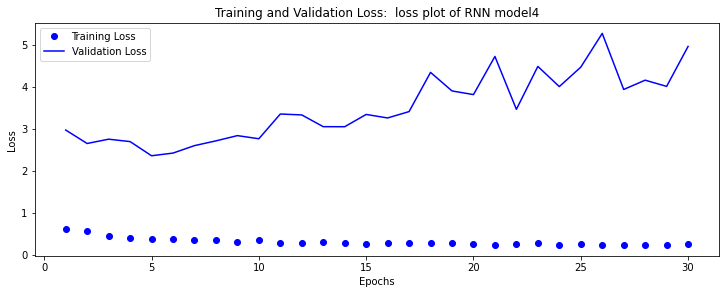

In [10]:
RNN_model4 = models.Sequential()
RNN_model4.add(layers.SimpleRNN(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model4.add(layers.SimpleRNN(50))


RNN_model4.add(layers.Dense(1))

RNN_model4.compile(optimizer=RMSprop(), loss='mse')
RNN_model4_history = RNN_model4.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model4_history, "loss plot of RNN model4")

Epoch 1/30
13/13 [==============================] - 6s 200ms/step - loss: 0.5370 - val_loss: 6.5937
Epoch 2/30
13/13 [==============================] - 2s 186ms/step - loss: 0.4841 - val_loss: 6.0632
Epoch 3/30
13/13 [==============================] - 2s 179ms/step - loss: 0.3407 - val_loss: 5.5591
Epoch 4/30
13/13 [==============================] - 2s 191ms/step - loss: 0.2494 - val_loss: 4.7060
Epoch 5/30
13/13 [==============================] - 3s 201ms/step - loss: 0.2418 - val_loss: 5.5539
Epoch 6/30
13/13 [==============================] - 2s 185ms/step - loss: 0.2082 - val_loss: 4.5487
Epoch 7/30
13/13 [==============================] - 2s 182ms/step - loss: 0.2082 - val_loss: 4.5378
Epoch 8/30
13/13 [==============================] - 2s 185ms/step - loss: 0.1809 - val_loss: 5.1988
Epoch 9/30
13/13 [==============================] - 2s 182ms/step - loss: 0.1573 - val_loss: 3.7832
Epoch 10/30
13/13 [==============================] - 2s 190ms/step - loss: 0.1988 - val_loss: 5.1102

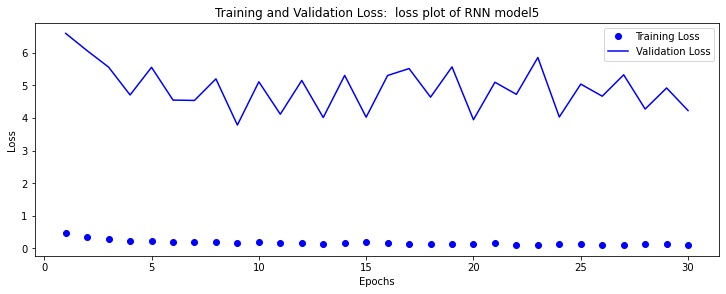

In [11]:
RNN_model5 = models.Sequential()
RNN_model5.add(layers.SimpleRNN(50, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model5.add(layers.SimpleRNN(50))


RNN_model5.add(layers.Dense(1))

RNN_model5.compile(optimizer=RMSprop(), loss='mse')
RNN_model5_history = RNN_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model5_history, "loss plot of RNN model5")

Epoch 1/30
13/13 [==============================] - 6s 266ms/step - loss: 0.5284 - val_loss: 5.1439
Epoch 2/30
13/13 [==============================] - 4s 281ms/step - loss: 0.6045 - val_loss: 4.8978
Epoch 3/30
13/13 [==============================] - 3s 231ms/step - loss: 0.4560 - val_loss: 4.6897
Epoch 4/30
13/13 [==============================] - 3s 230ms/step - loss: 0.3936 - val_loss: 4.2559
Epoch 5/30
13/13 [==============================] - 3s 214ms/step - loss: 0.3859 - val_loss: 4.2681
Epoch 6/30
13/13 [==============================] - 3s 205ms/step - loss: 0.3732 - val_loss: 4.2238
Epoch 7/30
13/13 [==============================] - 4s 325ms/step - loss: 0.3343 - val_loss: 4.1072
Epoch 8/30
13/13 [==============================] - 3s 232ms/step - loss: 0.3426 - val_loss: 4.1641
Epoch 9/30
13/13 [==============================] - 3s 225ms/step - loss: 0.3347 - val_loss: 4.1220
Epoch 10/30
13/13 [==============================] - 3s 262ms/step - loss: 0.3085 - val_loss: 4.4535

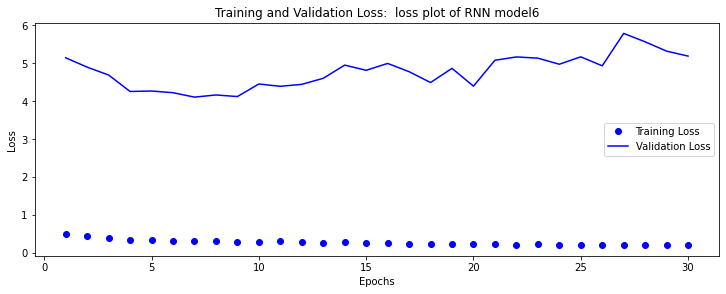

In [12]:
RNN_model6 = models.Sequential()
RNN_model6.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model6.add(layers.SimpleRNN(50))


RNN_model6.add(layers.Dense(1))

RNN_model6.compile(optimizer=RMSprop(), loss='mse')
RNN_model6_history = RNN_model6.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model6_history, "loss plot of RNN model6")

Epoch 1/40
13/13 [==============================] - 5s 203ms/step - loss: 0.4862 - val_loss: 8.0884
Epoch 2/40
13/13 [==============================] - 2s 159ms/step - loss: 0.4086 - val_loss: 7.5161
Epoch 3/40
13/13 [==============================] - 2s 172ms/step - loss: 0.3590 - val_loss: 7.1076
Epoch 4/40
13/13 [==============================] - 2s 162ms/step - loss: 0.3301 - val_loss: 6.7753
Epoch 5/40
13/13 [==============================] - 2s 178ms/step - loss: 0.3099 - val_loss: 6.5040
Epoch 6/40
13/13 [==============================] - 2s 171ms/step - loss: 0.2939 - val_loss: 6.2761
Epoch 7/40
13/13 [==============================] - 2s 163ms/step - loss: 0.2810 - val_loss: 6.0823
Epoch 8/40
13/13 [==============================] - 2s 174ms/step - loss: 0.2703 - val_loss: 5.9178
Epoch 9/40
13/13 [==============================] - 2s 180ms/step - loss: 0.2609 - val_loss: 5.7757
Epoch 10/40
13/13 [==============================] - 2s 179ms/step - loss: 0.2522 - val_loss: 5.6490

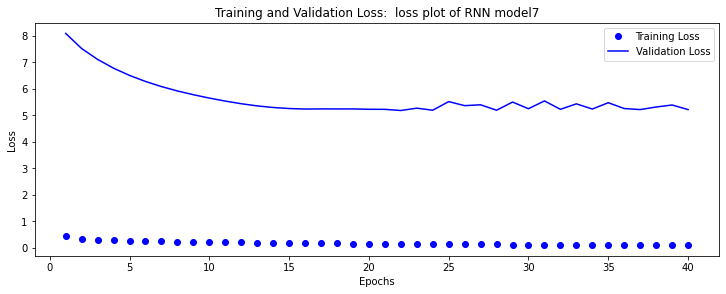

In [13]:
RNN_model7 = models.Sequential()
RNN_model7.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model7.add(layers.SimpleRNN(32))


RNN_model7.add(layers.Dense(1))

RNN_model7.compile(optimizer=RMSprop(), loss='mse')
RNN_model7_history = RNN_model7.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model7_history, "loss plot of RNN model7")

Epoch 1/30
13/13 [==============================] - 6s 207ms/step - loss: 0.5803 - val_loss: 8.8761
Epoch 2/30
13/13 [==============================] - 2s 186ms/step - loss: 0.5784 - val_loss: 8.2094
Epoch 3/30
13/13 [==============================] - 2s 187ms/step - loss: 0.4646 - val_loss: 7.5586
Epoch 4/30
13/13 [==============================] - 3s 219ms/step - loss: 0.4495 - val_loss: 7.2939
Epoch 5/30
13/13 [==============================] - 3s 215ms/step - loss: 0.4320 - val_loss: 6.9884
Epoch 6/30
13/13 [==============================] - 3s 191ms/step - loss: 0.4188 - val_loss: 6.8670
Epoch 7/30
13/13 [==============================] - 2s 176ms/step - loss: 0.3514 - val_loss: 6.4927
Epoch 8/30
13/13 [==============================] - 2s 191ms/step - loss: 0.3377 - val_loss: 6.2739
Epoch 9/30
13/13 [==============================] - 3s 264ms/step - loss: 0.3308 - val_loss: 6.2043
Epoch 10/30
13/13 [==============================] - 2s 180ms/step - loss: 0.3338 - val_loss: 6.0657

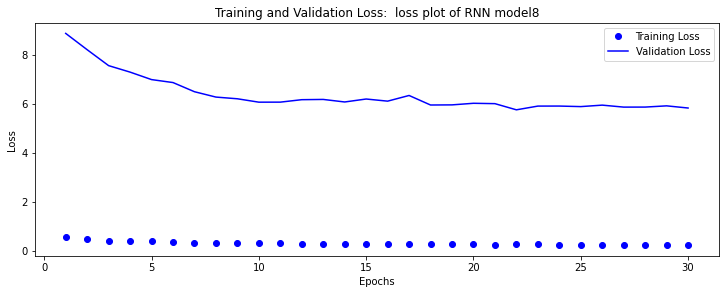

In [14]:
RNN_model8 = models.Sequential()
RNN_model8.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model8.add(layers.SimpleRNN(32))


RNN_model8.add(layers.Dense(1))

RNN_model8.compile(optimizer=RMSprop(), loss='mse')
RNN_model8_history = RNN_model8.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model8_history, "loss plot of RNN model8")

Epoch 1/20
13/13 [==============================] - 5s 191ms/step - loss: 0.5157 - val_loss: 11.2756
Epoch 2/20
13/13 [==============================] - 2s 169ms/step - loss: 0.3655 - val_loss: 10.2645
Epoch 3/20
13/13 [==============================] - 2s 179ms/step - loss: 0.3310 - val_loss: 9.6203
Epoch 4/20
13/13 [==============================] - 2s 180ms/step - loss: 0.3129 - val_loss: 9.1579
Epoch 5/20
13/13 [==============================] - 2s 162ms/step - loss: 0.2963 - val_loss: 8.8125
Epoch 6/20
13/13 [==============================] - 2s 167ms/step - loss: 0.2789 - val_loss: 8.5418
Epoch 7/20
13/13 [==============================] - 2s 170ms/step - loss: 0.2612 - val_loss: 8.3259
Epoch 8/20
13/13 [==============================] - 2s 178ms/step - loss: 0.2447 - val_loss: 8.1556
Epoch 9/20
13/13 [==============================] - 2s 178ms/step - loss: 0.2306 - val_loss: 8.0237
Epoch 10/20
13/13 [==============================] - 2s 173ms/step - loss: 0.2190 - val_loss: 7.92

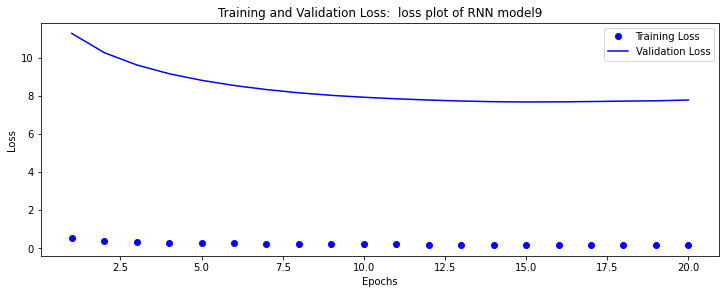

In [15]:
RNN_model9 = models.Sequential()
RNN_model9.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model9.add(layers.SimpleRNN(16))


RNN_model9.add(layers.Dense(1))

RNN_model9.compile(optimizer=RMSprop(), loss='mse')
RNN_model9_history = RNN_model9.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model9_history, "loss plot of RNN model9")

Epoch 1/20
13/13 [==============================] - 5s 213ms/step - loss: 0.9937 - val_loss: 15.7168
Epoch 2/20
13/13 [==============================] - 2s 177ms/step - loss: 0.5717 - val_loss: 13.2154
Epoch 3/20
13/13 [==============================] - 2s 194ms/step - loss: 0.5294 - val_loss: 11.7995
Epoch 4/20
13/13 [==============================] - 3s 193ms/step - loss: 0.4775 - val_loss: 11.0580
Epoch 5/20
13/13 [==============================] - 2s 187ms/step - loss: 0.4443 - val_loss: 10.2966
Epoch 6/20
13/13 [==============================] - 2s 187ms/step - loss: 0.4340 - val_loss: 9.8362
Epoch 7/20
13/13 [==============================] - 2s 188ms/step - loss: 0.3972 - val_loss: 9.4422
Epoch 8/20
13/13 [==============================] - 2s 182ms/step - loss: 0.4234 - val_loss: 9.3485
Epoch 9/20
13/13 [==============================] - 2s 192ms/step - loss: 0.3806 - val_loss: 8.8046
Epoch 10/20
13/13 [==============================] - 3s 194ms/step - loss: 0.3822 - val_loss: 8

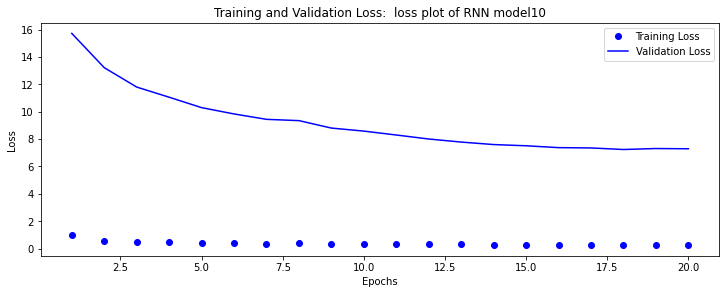

In [16]:
RNN_model10 = models.Sequential()
RNN_model10.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model10.add(layers.SimpleRNN(16))

RNN_model10.add(layers.Dense(1))

RNN_model10.compile(optimizer=RMSprop(), loss='mse')
RNN_model10_history = RNN_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model10_history, "loss plot of RNN model10")

Epoch 1/40
13/13 [==============================] - 5s 199ms/step - loss: 1.1726 - val_loss: 21.0772
Epoch 2/40
13/13 [==============================] - 2s 173ms/step - loss: 0.9001 - val_loss: 19.7760
Epoch 3/40
13/13 [==============================] - 2s 177ms/step - loss: 0.8160 - val_loss: 18.5920
Epoch 4/40
13/13 [==============================] - 2s 178ms/step - loss: 0.6569 - val_loss: 17.6538
Epoch 5/40
13/13 [==============================] - 2s 179ms/step - loss: 0.6269 - val_loss: 16.6748
Epoch 6/40
13/13 [==============================] - 2s 176ms/step - loss: 0.5362 - val_loss: 15.8704
Epoch 7/40
13/13 [==============================] - 2s 167ms/step - loss: 0.4992 - val_loss: 15.2170
Epoch 8/40
13/13 [==============================] - 2s 173ms/step - loss: 0.4681 - val_loss: 14.7187
Epoch 9/40
13/13 [==============================] - 2s 174ms/step - loss: 0.4611 - val_loss: 14.2596
Epoch 10/40
13/13 [==============================] - 2s 173ms/step - loss: 0.4476 - val_los

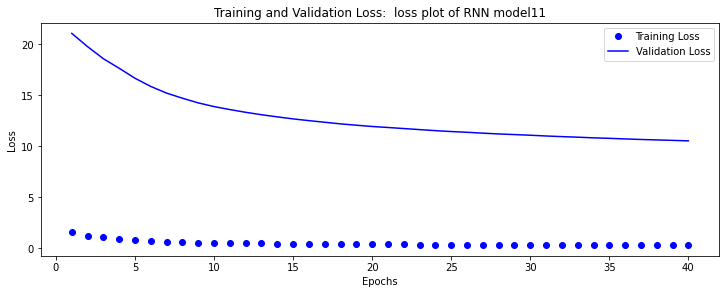

In [17]:
RNN_model11 = models.Sequential()
RNN_model11.add(layers.SimpleRNN(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model11.add(layers.SimpleRNN(5))


RNN_model11.add(layers.Dense(1))

RNN_model11.compile(optimizer=RMSprop(), loss='mse')
RNN_model11_history = RNN_model11.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model11_history, "loss plot of RNN model11")

Epoch 1/30
13/13 [==============================] - 11s 434ms/step - loss: 0.6547 - val_loss: 3.8444
Epoch 2/30
13/13 [==============================] - 3s 240ms/step - loss: 0.6247 - val_loss: 3.7983
Epoch 3/30
13/13 [==============================] - 4s 289ms/step - loss: 0.5453 - val_loss: 3.6628
Epoch 4/30
13/13 [==============================] - 4s 349ms/step - loss: 0.4693 - val_loss: 3.6464
Epoch 5/30
13/13 [==============================] - 4s 317ms/step - loss: 0.4546 - val_loss: 3.3563
Epoch 6/30
13/13 [==============================] - 3s 259ms/step - loss: 0.4214 - val_loss: 3.2662
Epoch 7/30
13/13 [==============================] - 3s 222ms/step - loss: 0.3912 - val_loss: 3.4031
Epoch 8/30
13/13 [==============================] - 3s 242ms/step - loss: 0.3681 - val_loss: 3.6094
Epoch 9/30
13/13 [==============================] - 4s 301ms/step - loss: 0.3526 - val_loss: 3.3961
Epoch 10/30
13/13 [==============================] - 3s 261ms/step - loss: 0.3957 - val_loss: 3.901

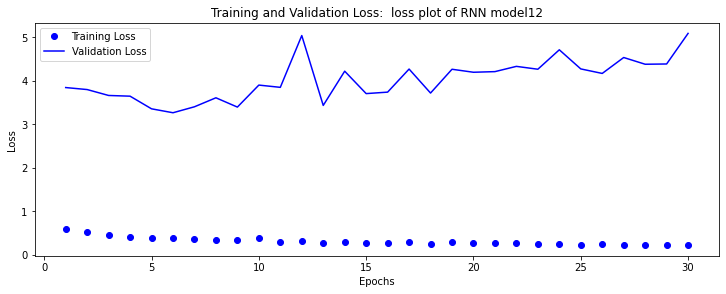

In [18]:
RNN_model12 = models.Sequential()
RNN_model12.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model12.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))

RNN_model12.add(layers.SimpleRNN(50))


RNN_model12.add(layers.Dense(1))

RNN_model12.compile(optimizer=RMSprop(), loss='mse')
RNN_model12_history = RNN_model12.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model12_history, "loss plot of RNN model12")

Epoch 1/30
13/13 [==============================] - 8s 371ms/step - loss: 0.6972 - val_loss: 3.7461
Epoch 2/30
13/13 [==============================] - 4s 281ms/step - loss: 1.0431 - val_loss: 4.1596
Epoch 3/30
13/13 [==============================] - 4s 298ms/step - loss: 0.6506 - val_loss: 3.9601
Epoch 4/30
13/13 [==============================] - 6s 449ms/step - loss: 0.5694 - val_loss: 3.8880
Epoch 5/30
13/13 [==============================] - 4s 284ms/step - loss: 0.6074 - val_loss: 3.7094
Epoch 6/30
13/13 [==============================] - 4s 275ms/step - loss: 0.4813 - val_loss: 3.5820
Epoch 7/30
13/13 [==============================] - 6s 482ms/step - loss: 0.4848 - val_loss: 3.8034
Epoch 8/30
13/13 [==============================] - 5s 364ms/step - loss: 0.5145 - val_loss: 3.9652
Epoch 9/30
13/13 [==============================] - 4s 301ms/step - loss: 0.3859 - val_loss: 3.7062
Epoch 10/30
13/13 [==============================] - 4s 293ms/step - loss: 0.4237 - val_loss: 3.8023

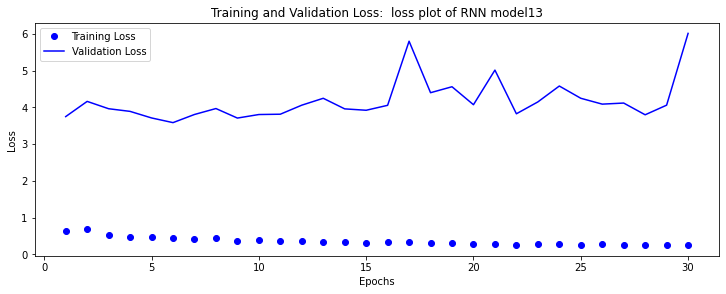

In [19]:
RNN_model13 = models.Sequential()
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50))


RNN_model13.add(layers.Dense(1))

RNN_model13.compile(optimizer=RMSprop(), loss='mse')
RNN_model13_history = RNN_model13.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model13_history, "loss plot of RNN model13")

Epoch 1/20
13/13 [==============================] - 4s 170ms/step - loss: 0.4202 - val_loss: 6.5744
Epoch 2/20
13/13 [==============================] - 3s 229ms/step - loss: 0.4403 - val_loss: 6.4423
Epoch 3/20
13/13 [==============================] - 2s 135ms/step - loss: 0.3776 - val_loss: 6.0105
Epoch 4/20
13/13 [==============================] - 2s 142ms/step - loss: 0.2982 - val_loss: 5.9276
Epoch 5/20
13/13 [==============================] - 2s 197ms/step - loss: 0.2581 - val_loss: 5.7079
Epoch 6/20
13/13 [==============================] - 2s 148ms/step - loss: 0.2307 - val_loss: 5.8233
Epoch 7/20
13/13 [==============================] - 2s 140ms/step - loss: 0.2056 - val_loss: 6.0914
Epoch 8/20
13/13 [==============================] - 3s 255ms/step - loss: 0.1809 - val_loss: 6.1381
Epoch 9/20
13/13 [==============================] - 2s 135ms/step - loss: 0.1602 - val_loss: 5.7888
Epoch 10/20
13/13 [==============================] - 3s 188ms/step - loss: 0.1417 - val_loss: 6.4975

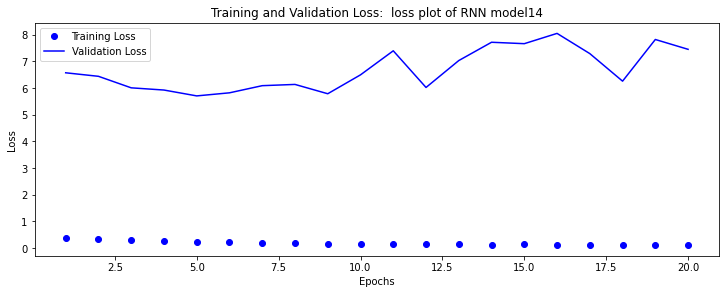

In [20]:
RNN_model14 = models.Sequential()
RNN_model14.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model14.add(layers.SimpleRNN(32))

RNN_model14.add(layers.Dense(1))

RNN_model14.compile(optimizer=RMSprop(), loss='mse')
RNN_model14_history = RNN_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model14_history, "loss plot of RNN model14")

Epoch 1/20
13/13 [==============================] - 3s 147ms/step - loss: 0.6987 - val_loss: 12.1687
Epoch 2/20
13/13 [==============================] - 2s 149ms/step - loss: 0.4569 - val_loss: 10.8311
Epoch 3/20
13/13 [==============================] - 2s 138ms/step - loss: 0.4028 - val_loss: 10.1333
Epoch 4/20
13/13 [==============================] - 2s 145ms/step - loss: 0.3614 - val_loss: 9.6714
Epoch 5/20
13/13 [==============================] - 2s 183ms/step - loss: 0.3288 - val_loss: 9.3157
Epoch 6/20
13/13 [==============================] - 2s 134ms/step - loss: 0.3038 - val_loss: 9.0227
Epoch 7/20
13/13 [==============================] - 2s 135ms/step - loss: 0.2848 - val_loss: 8.7760
Epoch 8/20
13/13 [==============================] - 2s 183ms/step - loss: 0.2699 - val_loss: 8.5614
Epoch 9/20
13/13 [==============================] - 2s 141ms/step - loss: 0.2581 - val_loss: 8.3686
Epoch 10/20
13/13 [==============================] - 2s 121ms/step - loss: 0.2485 - val_loss: 8.1

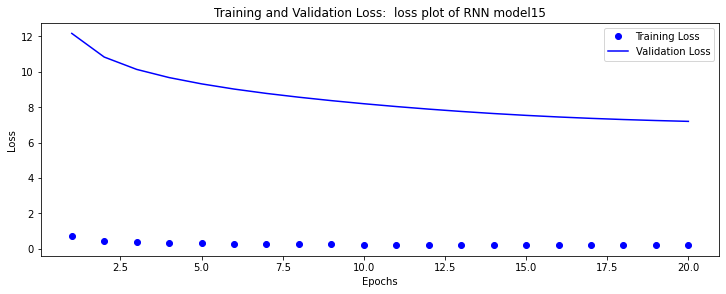

In [21]:
RNN_model15 = models.Sequential()
RNN_model15.add(layers.SimpleRNN(16, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model15.add(layers.SimpleRNN(16))

RNN_model15.add(layers.Dense(1))

RNN_model15.compile(optimizer=RMSprop(), loss='mse')
RNN_model15_history = RNN_model15.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model15_history, "loss plot of RNN model15")

Epoch 1/20
13/13 [==============================] - 4s 181ms/step - loss: 0.6200 - val_loss: 5.5254
Epoch 2/20
13/13 [==============================] - 2s 146ms/step - loss: 0.5425 - val_loss: 4.6170
Epoch 3/20
13/13 [==============================] - 2s 162ms/step - loss: 0.4155 - val_loss: 4.2248
Epoch 4/20
13/13 [==============================] - 3s 229ms/step - loss: 0.3327 - val_loss: 3.8903
Epoch 5/20
13/13 [==============================] - 2s 165ms/step - loss: 0.2873 - val_loss: 3.5326
Epoch 6/20
13/13 [==============================] - 4s 327ms/step - loss: 0.2845 - val_loss: 3.7784
Epoch 7/20
13/13 [==============================] - 3s 234ms/step - loss: 0.2467 - val_loss: 3.1205
Epoch 8/20
13/13 [==============================] - 2s 162ms/step - loss: 0.2230 - val_loss: 3.4834
Epoch 9/20
13/13 [==============================] - 3s 243ms/step - loss: 0.2400 - val_loss: 2.7986
Epoch 10/20
13/13 [==============================] - 2s 161ms/step - loss: 0.1970 - val_loss: 3.4743

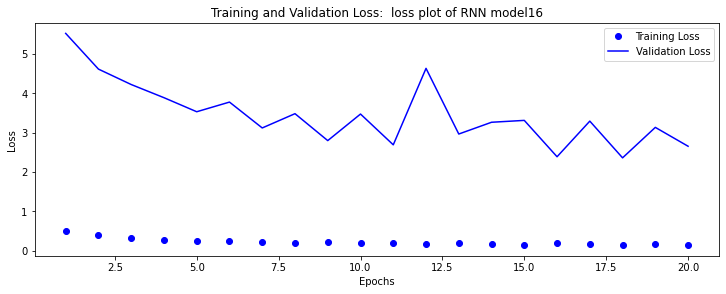

In [22]:
RNN_model16 = models.Sequential()
RNN_model16.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model16.add(layers.SimpleRNN(64))

RNN_model16.add(layers.Dense(1))

RNN_model16.compile(optimizer=RMSprop(), loss='mse')
RNN_model16_history = RNN_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model16_history, "loss plot of RNN model16")

Epoch 1/20
13/13 [==============================] - 9s 383ms/step - loss: 0.5300 - val_loss: 7.2967
Epoch 2/20
13/13 [==============================] - 3s 194ms/step - loss: 0.5208 - val_loss: 6.8252
Epoch 3/20
13/13 [==============================] - 3s 234ms/step - loss: 0.4146 - val_loss: 6.2813
Epoch 4/20
13/13 [==============================] - 2s 180ms/step - loss: 0.3441 - val_loss: 5.9690
Epoch 5/20
13/13 [==============================] - 3s 224ms/step - loss: 0.2987 - val_loss: 5.7880
Epoch 6/20
13/13 [==============================] - 2s 184ms/step - loss: 0.2777 - val_loss: 5.9052
Epoch 7/20
13/13 [==============================] - 2s 173ms/step - loss: 0.2490 - val_loss: 5.9713
Epoch 8/20
13/13 [==============================] - 3s 224ms/step - loss: 0.2412 - val_loss: 6.3870
Epoch 9/20
13/13 [==============================] - 2s 175ms/step - loss: 0.2379 - val_loss: 6.5873
Epoch 10/20
13/13 [==============================] - 3s 251ms/step - loss: 0.2908 - val_loss: 5.5849

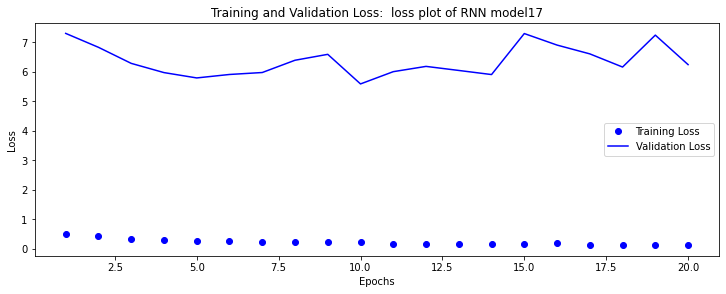

In [23]:
RNN_model17 = models.Sequential()
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32))
RNN_model17.add(layers.Dense(1))

RNN_model17.compile(optimizer=RMSprop(), loss='mse')
RNN_model17_history = RNN_model17.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model17_history, "loss plot of RNN model17")

Epoch 1/20
13/13 [==============================] - 5s 237ms/step - loss: 0.4321 - val_loss: 7.1095
Epoch 2/20
13/13 [==============================] - 2s 180ms/step - loss: 0.7373 - val_loss: 6.9071
Epoch 3/20
13/13 [==============================] - 2s 156ms/step - loss: 0.5072 - val_loss: 6.6023
Epoch 4/20
13/13 [==============================] - 3s 247ms/step - loss: 0.4199 - val_loss: 6.2562
Epoch 5/20
13/13 [==============================] - 2s 177ms/step - loss: 0.3896 - val_loss: 6.0404
Epoch 6/20
13/13 [==============================] - 3s 242ms/step - loss: 0.3580 - val_loss: 5.8688
Epoch 7/20
13/13 [==============================] - 2s 196ms/step - loss: 0.3289 - val_loss: 5.7351
Epoch 8/20
13/13 [==============================] - 2s 173ms/step - loss: 0.3048 - val_loss: 5.6292
Epoch 9/20
13/13 [==============================] - 3s 220ms/step - loss: 0.2851 - val_loss: 5.5450
Epoch 10/20
13/13 [==============================] - 2s 180ms/step - loss: 0.2681 - val_loss: 5.4749

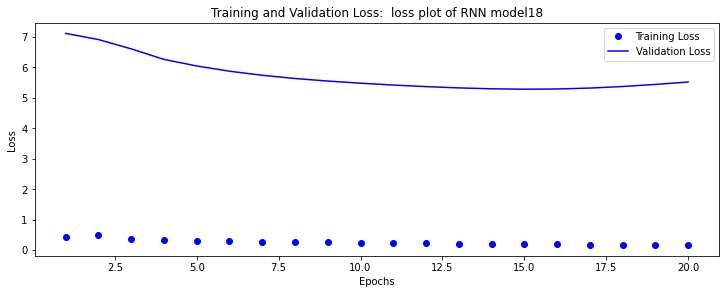

In [24]:
RNN_model18 = models.Sequential()
RNN_model18.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model18.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model18.add(layers.SimpleRNN(32))

RNN_model18.add(layers.Dense(1))

RNN_model18.compile(optimizer=RMSprop(), loss='mse')
RNN_model18_history = RNN_model18.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model18_history, "loss plot of RNN model18")

In [25]:
histories = [RNN_model1_history, RNN_model2_history, RNN_model3_history, RNN_model4_history, RNN_model5_history, RNN_model6_history, RNN_model7_history, RNN_model8_history, RNN_model9_history, RNN_model10_history, RNN_model11_history, RNN_model12_history, RNN_model13_history, RNN_model14_history, RNN_model15_history, RNN_model16_history, RNN_model17_history, RNN_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 2.5263378620147705, epoch: 14
Model 2: min val loss: 2.010007381439209, epoch: 10
Model 3: min val loss: 3.102067232131958, epoch: 18
Model 4: min val loss: 2.3562276363372803, epoch: 5
Model 5: min val loss: 3.7831602096557617, epoch: 9
Model 6: min val loss: 4.1071906089782715, epoch: 7
Model 7: min val loss: 5.180365085601807, epoch: 22
Model 8: min val loss: 5.753314971923828, epoch: 22
Model 9: min val loss: 7.67692756652832, epoch: 15
Model 10: min val loss: 7.2413010597229, epoch: 18
Model 11: min val loss: 10.534610748291016, epoch: 40
Model 12: min val loss: 3.2662105560302734, epoch: 6
Model 13: min val loss: 3.5820164680480957, epoch: 6
Model 14: min val loss: 5.7078752517700195, epoch: 5
Model 15: min val loss: 7.196586608886719, epoch: 20
Model 16: min val loss: 2.3602442741394043, epoch: 18
Model 17: min val loss: 5.584926605224609, epoch: 10
Model 18: min val loss: 5.278287410736084, epoch: 15
